# Imports


In [21]:
import random
import pprint
from operator import itemgetter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import data

In [2]:
raw_data6 = pd.read_csv('data/scenario6.labeled', delimiter='\s+', low_memory=False)
# raw_data10 = pd.read_csv('data/scenario10.labeled', delimiter='\s+')

In [3]:
def parse_data(raw):
    data = raw
    data['Date'] = data['Date'].map(str) + " " + data['flow']

    src_ip_port = data['Prot'].map(str).str.split(':', n=1, expand = True)
    dst_ip_port = data['IP'].map(str).str.split(':', n=1, expand = True)
    data['src_ip'] = src_ip_port[0]
    data['src_port'] = src_ip_port[1]
    data['dst_ip'] = dst_ip_port[0]
    data['dst_port'] = dst_ip_port[1]

    data.drop(['flow', 'Src','Packets', 'Bytes', 'Flows', 'Prot', 'IP', 'Label', 'Labels'], axis=1, inplace=True)
    data.rename(columns={'start':'duration', 'Date':'start','Durat':'protocol', 'Addr:Port':'flags', 'Dst':'tos', 'IP.1':'packets', 'Addr:Port.1':'bytes', 'Flags':'flows', 'Tos':'label'}, inplace=True)
    data.sort_values(by='start', inplace=True)
    
    return data

In [4]:
data6 = parse_data(raw_data6)
print(data6.head())
print(data6['label'].unique())

                     start  duration protocol flags  tos  packets    bytes  \
0  2011-08-16 10:01:46.972     4.933      TCP    A_    0      537    37374   
1  2011-08-16 10:01:46.974     4.929      TCP   PA_    0      936  1417104   
2  2011-08-16 10:01:46.974     4.999      TCP   PA_    0      949   208122   
3  2011-08-16 10:01:46.976     0.000      UDP   INT    0        1      174   
4  2011-08-16 10:01:46.977     0.009      TCP   RA_    0        4      264   

   flows       label           src_ip src_port         dst_ip dst_port  
0      1  Background    88.176.79.163    49213  147.32.84.172    18250  
1      1  Background    147.32.84.172    18250  88.176.79.163    49213  
2      1  Background    147.32.85.112       22   85.70.14.207    10005  
3      1  Background      90.178.10.8    61997  147.32.84.229    13363  
4      1  Background  117.211.100.130    43458   147.32.86.92       80  
['Background' 'LEGITIMATE' 'Botnet']


# Sampling

### Obtain IP addresses to sample

In [5]:
df = data6
infected_ip = '147.32.84.165'

src_rows_with_infected_ip = df[df['src_ip'] == infected_ip]
dst_df = src_rows_with_infected_ip['dst_ip']
from_infected = dst_df.values

dst_rows_with_infected_ip = df[df['dst_ip'] == infected_ip]
src_df = dst_rows_with_infected_ip['src_ip']
to_infected = src_df.values

nr_of_unique_ips = len(np.unique(from_infected))

print(f'IP {infected_ip} sends packets to {nr_of_unique_ips} unique IP addresses.')    

IP 147.32.84.165 sends packets to 1582 unique IP addresses.


### Reservoir Sampling


Estimate the distribution over the other IP_addresses, what are the 10 most frequent values?
Write code for RESERVOIR sampling, use it to estimate the distribution in one pass (no need to
actually stream the data, you may store it in memory, or run every file separately, but do store
and load the intermediate results). Use a range of reservoir sizes. What are the 10 most frequent
IP-addresses and their frequencies when sampled? Use the theory to explain any approximation
errors you observe

Implemented correctly, explanation accurate

In [6]:
# random_replace replaces a random element in sample with ip
def random_replace(sample, ip):
    r = random.randint(0, len(sample) - 1)
    sample[r] = ip    

# reservoir_sample performs reservoir sampling on the stream
def reservoir_sample(stream, reservoir_size):
    sample = []
    for i, ip in enumerate(stream):
        if i < reservoir_size:
            # Fill sample first
            sample.append(ip)
        else:
            # Probability that the next item should be sampled
            proba = reservoir_size / (i + 1)
            # Draw random number, if smaller than proba it should be sampled
            r = random.random()
            if r <= proba:
                # Element should be sampled
                random_replace(sample, ip)
    return sample

# aggregate counts the occurences per IP
def aggregate(ips, return_n_best=None):
    counts = {}
    for ip in ips:
        if ip not in counts:
            counts.update({ip: 0})
        counts[ip] += 1
    if return_n_best is None:
        return counts
    else:
        counts = counts.items()
        return sorted(counts, key=itemgetter(1), reverse=True)[:return_n_best]    

# overlap computes the number of elements which are estimated 'correctly'
def overlap(real, estimate):
    real = set([ip for (ip, _) in real])
    estimate = [ip for (ip, _) in estimate]
    count = 0
    for e in estimate:
        if e in real:
            count +=1            
    return count

# Create a largest-first distribution from the number of occurences per IP
def distribution_from_counts_dict(d: dict):
    counts_list = [v for v in d.values()]
    return sorted(counts_list, reverse=True)

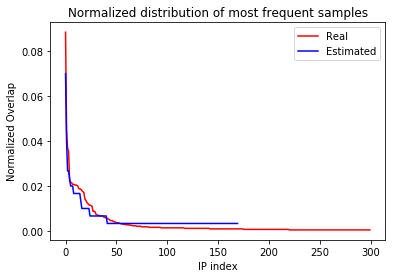

In [39]:
reservoir_size = 300

# Real distribution
real = aggregate(from_infected)
real_distribution = distribution_from_counts_dict(real)[:reservoir_size]
real_total = sum(real_distribution)
# After 400, only 1 connection
real_normalized = [e/real_total for e in real_distribution]

sample = reservoir_sample(from_infected, reservoir_size)
estimated = aggregate(sample)
estimated_distribution = distribution_from_counts_dict(estimated)
estimated_total = sum(estimated_distribution)
estimated_normalized = [e/estimated_total for e in estimated_distribution]

plt.figure()
plt.plot(real_normalized, label='Real', color='red')
plt.plot(estimated_normalized , label='Estimated', color='blue')
plt.xlabel('IP index')
plt.ylabel('Normalized Overlap')
plt.title('Normalized distribution of most frequent samples')
plt.legend()
plt.show()

In [50]:
best_n = 10
n_runs = 500
reservoir_sizes = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]

real = aggregate(from_infected, best_n)
print(f'Real {best_n} most frequent values:')
pprint.pprint(real)

sample = reservoir_sample(from_infected, 300)
estimated = aggregate(sample, best_n)
print(f'\nEstimated {best_n} most frequent values:')
pprint.pprint(estimated)

print(overlap(real, estimated))
ip_overlaps = []
for reservoir_size in reservoir_sizes:
    ip_overlap = 0
    for _ in range(n_runs):
        sample = reservoir_sample(from_infected, reservoir_size)
        estimated = aggregate(sample, best_n)
        ip_overlap += overlap(real, estimated)
    ip_overlap /= n_runs
    ip_overlaps.append(ip_overlap)
    print(f'Reservoir size {reservoir_size} average overlap for {best_n} most used ips: {ip_overlap}')

Real 10 most frequent values:
[('91.212.135.158', 384),
 ('64.59.134.8', 194),
 ('24.71.223.11', 160),
 ('216.32.180.22', 154),
 ('65.55.37.72', 96),
 ('65.55.37.88', 94),
 ('65.55.92.136', 93),
 ('65.55.92.168', 90),
 ('65.55.92.152', 90),
 ('202.108.252.141', 89)]

Estimated 10 most frequent values:
[('91.212.135.158', 20),
 ('202.108.252.141', 11),
 ('64.59.134.8', 11),
 ('24.71.223.11', 8),
 ('65.55.92.168', 7),
 ('65.55.37.104', 6),
 ('65.55.37.120', 6),
 ('65.54.188.126', 5),
 ('74.125.157.27', 5),
 ('65.55.92.184', 5)]
5
Reservoir size 1 average overlap for 10 most used ips: 0.22
Reservoir size 50 average overlap for 10 most used ips: 3.696
Reservoir size 100 average overlap for 10 most used ips: 5.05
Reservoir size 150 average overlap for 10 most used ips: 5.55
Reservoir size 200 average overlap for 10 most used ips: 5.74
Reservoir size 250 average overlap for 10 most used ips: 5.998
Reservoir size 300 average overlap for 10 most used ips: 6.266
Reservoir size 350 average overl

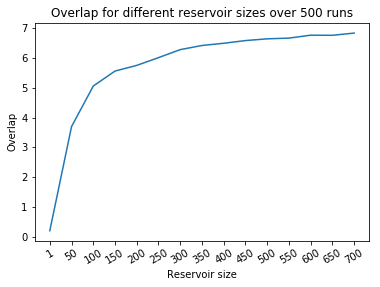

In [51]:
plt.figure()
plt.plot(ip_overlaps)
plt.xticks(np.arange(len(reservoir_sizes)), reservoir_sizes, rotation=30)
plt.xlabel('Reservoir size')
plt.ylabel('Overlap')
plt.title(f'Overlap for different reservoir sizes over {n_runs} runs')
plt.show()

# Sketching

Build code for computing a COUNT-MIN sketch, play with different heights and widths for the Count-Min sketch matrix. Compare it to the RESERVOIR sampling strategy. Is it more spaceefficient/accurate? What about run-time? Use the theory to explain any differences you observe.

Implemented correctly, analysis, and evaluation are sound

### COUNT-MIN Sketch

In [74]:
# _memomask = {}

# This function returns a (semi)unique hash function. 
# A new hash function is created based on the built-in hash function,
# but with a seeded random mask. Based on a stackoverflow code snippet.
# source: https://stackoverflow.com/questions/2255604/hash-functions-family-generator-in-python
def hash_function(n, w):
    random.seed(n)
    mask = random.getrandbits(64)
        
    def myhash(x):
        return (hash(x) ^ mask) % w
    
    return myhash

# Create a matrix with counts
def count_min_sketch(stream, w, d):
    cm = np.zeros((d, w), dtype=int)
    hash_functions = [hash_function(i, w) for i in range(d)]
    for e in stream:
        for i, hi in enumerate(hash_functions):
            v = hi(e)
            cm[i, v] += 1
    return cm, hash_functions

# Estimate occurence of a list of ips
def estimate_occurences(cm, hash_functions, ips):
    res = []
    for ip in ips:
        min_occurence = None
        for i, hi in enumerate(hash_functions):
            v = cm[i, hi(ip)]
            if min_occurence is None or min_occurence > v:
                min_occurence = v
        res.append((ip, min_occurence))
    return res

# w = 2 / epsilon
# epsilon = 2 / w
# d = log(1/delta)
# Map hash function to [1...w]
# resulting count is overestimate

In [115]:
stream = from_infected
# width
w = 50
# n_hash_functions, depth/height
d = 5
cm, hs = count_min_sketch(stream, w, d)
# ips = [ip for (ip, occ) in real]
unique_ips = np.unique(from_infected)
estimates = sorted(estimate_occurences(cm, hs, unique_ips), key=itemgetter(1), reverse=True)
print(estimates[:10])
print(overlap(real, estimates[:10]))

for w in [1, 10, 50, 100, 1000]:
    for d in [1, 5, 10, 50, 100, 1000]:
        cm, hs = count_min_sketch(stream, w, d)
        unique_ips = np.unique(from_infected)
        estimates = sorted(estimate_occurences(cm, hs, unique_ips), key=itemgetter(1), reverse=True)
        print(f'{w}, {d}, {overlap(real, estimates[:10])}, {estimates[:10][0][1]}')

print(real)

# for i, (ip, occ) in enumerate(real):
#     print(f'IP: {ip}, real occurences: {occ}, predicted occurences: {estimates[i][1]}')

[('91.212.135.158', 411), ('64.59.134.8', 215), ('24.71.223.11', 183), ('216.32.180.22', 166), ('65.55.92.168', 133), ('64.98.36.4', 115), ('65.55.92.136', 115), ('202.108.252.141', 114), ('65.55.37.72', 112), ('65.55.37.88', 110)]
9
1, 1, 0, 5724
1, 5, 0, 5724
1, 10, 0, 5724
1, 50, 0, 5724
1, 100, 0, 5724
1, 1000, 0, 5724
10, 1, 0, 1018
10, 5, 1, 705
10, 10, 4, 685
10, 50, 6, 593
10, 100, 8, 593
10, 1000, 7, 584
50, 1, 0, 428
50, 5, 7, 428
50, 10, 9, 428
50, 50, 10, 407
50, 100, 10, 405
50, 1000, 10, 405
100, 1, 0, 411
100, 5, 9, 411
100, 10, 9, 403
100, 50, 9, 395
100, 100, 9, 390
100, 1000, 9, 388
1000, 1, 2, 395
1000, 5, 9, 384
1000, 10, 10, 384
1000, 50, 10, 384
1000, 100, 10, 384
1000, 1000, 10, 384
[('91.212.135.158', 384), ('64.59.134.8', 194), ('24.71.223.11', 160), ('216.32.180.22', 154), ('65.55.37.72', 96), ('65.55.37.88', 94), ('65.55.92.136', 93), ('65.55.92.168', 90), ('65.55.92.152', 90), ('202.108.252.141', 89)]


In [133]:
print(len(from_infected))

5724
